In [167]:
import tensorflow as tf
import librosa
import os
from IPython.display import display, Audio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse
from tensorflow.contrib import rnn
from sys import stderr


Starting new analysis
SPCC_in_spec.png
SPCC_rnn_hu1_fb1_content.png


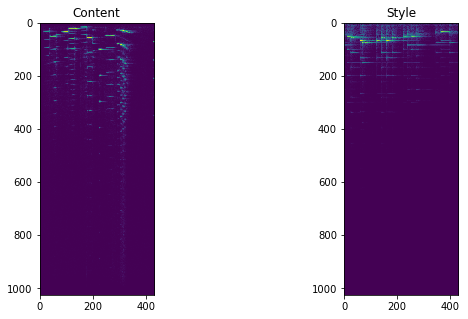

(1, 430, 1025)
('example input slice shape ', TensorShape([Dimension(1), Dimension(1025)]))
('output shape', TensorShape([Dimension(430), Dimension(1)]))
('out dimension', TensorShape([Dimension(430), Dimension(1)]))
('out_transform dimension', TensorShape([Dimension(430), Dimension(1)]))
Calculating style gram matrix
Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 0.000000
  Number of iterations: 3
  Number of functions evaluations: 4
('\n\nFinal loss:', 3.6835957e-10)



('a shape', (1025, 430))
('result[0]', array([[  1.17869459e-01,   1.13641836e-01,   1.11231305e-01, ...,
          9.60504860e-02,   8.60636532e-02,   5.95087744e-02],
       [  6.86565265e-02,   5.26747815e-02,   6.02909178e-02, ...,
          4.85718101e-02,   4.34323065e-02,   1.45885140e-01],
       [  1.75360795e-02,   1.16692157e-02,   5.14031854e-03, ...,
          5.86021831e-03,   2.18034722e-03,   1.

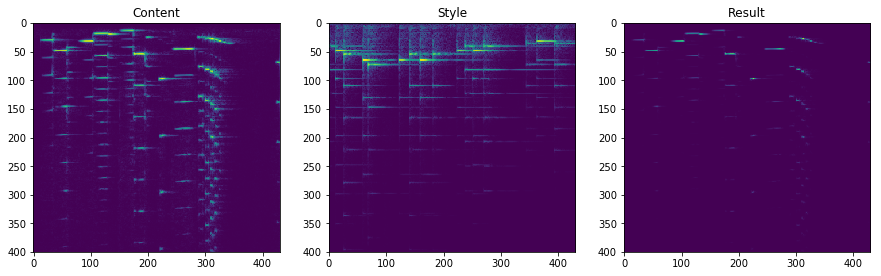

difference to content 2089.3
difference to style 2197.83


In [183]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectrum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

## potential files:
# "neural-style-audio-tf/inputs/bach_violin.mp3"
# "neural-style-audio-tf/inputs/clarinet_widmann1.mp3"
# "neural-style-audio-tf/inputs/piano_debussy.mp3"

## CHANGE as desired
content = True
num_hidden_units = 1
fb = 1.0
batch_size = 1

contents = ["neural-style-audio-tf/inputs/clarinet_widmann1.mp3", "neural-style-audio-tf/inputs/clarinet_widmann1.mp3", "neural-style-audio-tf/inputs/bach_violin.mp3", "neural-style-audio-tf/inputs/piano_debussy.mp3", "neural-style-audio-tf/inputs/bach_violin.mp3", "neural-style-audio-tf/inputs/piano_debussy.mp3"]
styles = ["neural-style-audio-tf/inputs/piano_debussy.mp3", "neural-style-audio-tf/inputs/bach_violin.mp3", "neural-style-audio-tf/inputs/piano_debussy.mp3", "neural-style-audio-tf/inputs/clarinet_widmann1.mp3", "neural-style-audio-tf/inputs/clarinet_widmann1.mp3", "neural-style-audio-tf/inputs/bach_violin.mp3"]
comparisons = ["SPCC_", "SVCC_", "SPCV_", "SCCP_", "SCCV_", "SVCP_"]

# contents = ["neural-style-audio-tf/inputs/clarinet_widmann1.mp3"]
# styles = ["neural-style-audio-tf/inputs/piano_debussy.mp3"]
# comparisons = ["SPCC_"]




## Naming
for i in range(len(contents)):
    print("Starting new analysis")
    CONTENT_FILENAME = contents[i]
    STYLE_FILENAME = styles[i]
    comparison = comparisons[i]
   
    if content:
        content_str = "_content"
    else:
        content_str = ""
    spec_name = 'rnn_hu' + str(num_hidden_units) + '_fb' + str(int(fb)) + content_str

    fig1_name = comparison + "in_spec.png"
    fig2_name = comparison + spec_name + '.png'
    print fig1_name
    print fig2_name

    display(Audio(CONTENT_FILENAME))
    display(Audio(STYLE_FILENAME))
    
    # get the spectograms for the content and style references
    a_content, fs = read_audio_spectrum(CONTENT_FILENAME)
    a_style, fs = read_audio_spectrum(STYLE_FILENAME)

    N_CHANNELS = a_content.shape[0]
    N_SAMPLES = a_content.shape[1]
    a_style = a_style[:N_CHANNELS, :N_SAMPLES]

    num_features = N_CHANNELS # size of each input vector
    time_steps = N_SAMPLES # number of input vectors to expect
    
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Content')
    plt.imshow(a_content[:,:]) # Clipping images
    plt.subplot(1, 2, 2)
    plt.title('Style')
    plt.imshow(a_style[:,:])
    plt.savefig(fig1_name)
    plt.show()
    
    # Feed these into input
    a_content_tf = np.ascontiguousarray(a_content.T[None,:,:])
    a_style_tf = np.ascontiguousarray(a_style.T[None,:,:])
    #w_val = np.random.randn(out.shape[1], out.shape[1])
    #b_val = np.random.randn(out.shape[0], out.shape[1])

    print a_content_tf.shape


    g = tf.Graph()

    with g.as_default(), g.device('/cpu:0'):

        # randomize initial state of rnn
        x = tf.placeholder("float32", [1, time_steps, num_features], name="x")
        
        inp = tf.unstack(x, time_steps, 1) # input to rnn
        print('example input slice shape ', inp[0].shape)

        lstm_layer = tf.contrib.rnn.BasicLSTMCell(num_hidden_units, forget_bias=fb)
        init_state = lstm_layer.zero_state(batch_size, tf.float32)
        outputs, state = tf.contrib.rnn.static_rnn(lstm_layer, inp, initial_state=init_state, dtype="float32")
        out = tf.concat(outputs, 0)
        print('output shape', out.shape)
        
        
        ## Testing applying randomized weights to output
        #w = tf.placeholder("float32", [out.shape[1], 1], name="w")
        #b = tf.placeholder("float32", out.shape, name="b")
        #out_transform = tf.matmul(out, w) + b

        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            
            #content_features = sess.run(out_transform, feed_dict={x:a_content_tf, w: w_val, b:b_val})
            #style_features = sess.run(out, feed_dict={x:a_style_tf, w: w_val, b:b_val})

            content_features = sess.run(out, feed_dict={x:a_content_tf})
            style_features = sess.run(out, feed_dict={x:a_style_tf})
            style_gram = np.matmul(style_features.T, style_features) / N_SAMPLES
            

    ALPHA= 1e-2
    learning_rate= 1e-3
    iterations = 100

    result = None
    with tf.Graph().as_default():

        # Build graph with variable input
        #w = tf.Variable(np.random.randn(out.shape[1],out.shape[1]).astype(np.float32), name='w')
        #b = tf.Variable(np.random.randn(out.shape[0], out.shape[1]).astype(np.float32), name='b')
        if content:
            x = tf.Variable(a_content_tf)
        else:
            x = tf.Variable(np.random.randn(1,time_steps, num_features).astype(np.float32)*1e-3, name="x")

        inp = tf.unstack(x, time_steps, 1) # input to rnn

        lstm_layer = tf.contrib.rnn.BasicLSTMCell(num_hidden_units, forget_bias=fb)
        init_state = lstm_layer.zero_state(batch_size, tf.float32)
        outputs, state = tf.contrib.rnn.static_rnn(lstm_layer, inp, initial_state=init_state, dtype="float32")
        out = tf.concat(outputs, 0)
        #out_transform = tf.matmul(out, w) + b
        
        print('out dimension', out.shape)
        #print('out_transform dimension', out_transform.shape)

        if content:
            content_loss = 0
        else:
            #content_loss = ALPHA * 2 * tf.nn.l2_loss(
            #        out_transform - content_features)
            content_loss = ALPHA * 2 * tf.nn.l2_loss(
                    out - content_features)

        print("Calculating style gram matrix")
        #gram = tf.matmul(tf.transpose(out_transform), out_transform)  / N_SAMPLES
        gram = tf.matmul(tf.transpose(out), out)  / N_SAMPLES
        style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

         # Overall loss
        loss = content_loss + style_loss

        opt = tf.contrib.opt.ScipyOptimizerInterface(
              loss, method='L-BFGS-B', options={'maxiter': 300})

        # Optimization
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())

            print('Started optimization.')
            opt.minimize(sess)
        
            print('\n\nFinal loss:', loss.eval())
            print('\n\n')
            result = x.eval()
   

    a = np.zeros_like(a_content)
    print("a shape", a.shape)
    print('result[0]', result[0].T)
    a[:N_CHANNELS,:] = np.exp(result[0].T) - 1


    # This code is supposed to do phase reconstruction
    p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
    for i in range(500):
        S = a * np.exp(1j*p)
        x = librosa.istft(S)
        p = np.angle(librosa.stft(x, N_FFT))


    OUTPUT_FILENAME = 'neural-style-audio-tf/outputs/' + comparison + spec_name + '.wav' # TODO: Change this filename to not overwrite results
    librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

    
    print OUTPUT_FILENAME
    display(Audio(OUTPUT_FILENAME))
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('Content')
    plt.imshow(a_content[:400,:])
    plt.subplot(1,3,2)
    plt.title('Style')
    plt.imshow(a_style[:400,:])
    plt.subplot(1,3,3)
    plt.title('Result')
    plt.imshow(a[:400,:])
    plt.savefig(fig2_name)
    plt.show()
    
    ## Comparing result with content and style original files
    diff_to_content = np.absolute(a - a_content)
    diff_to_style = np.absolute(a - a_style)
    print "difference to content", np.linalg.norm(diff_to_content)
    print "difference to style", np.linalg.norm(diff_to_style)

In [169]:
# # Reads wav file and produces spectrum
# # Fourier phases are ignored
# N_FFT = 2048
# def read_audio_spectrum(filename):
#     x, fs = librosa.load(filename)
#     S = librosa.stft(x, N_FFT)
#     p = np.angle(S)
    
#     S = np.log1p(np.abs(S[:,:430]))  
#     return S, fs



In [170]:
# # get the spectograms for the content and style references
# a_content, fs = read_audio_spectrum(CONTENT_FILENAME)
# a_style, fs = read_audio_spectrum(STYLE_FILENAME)

# N_CHANNELS = a_content.shape[0]
# N_SAMPLES = a_content.shape[1]
# a_style = a_style[:N_CHANNELS, :N_SAMPLES]

# print np.shape(a_content)

# num_features = N_CHANNELS # size of each input vector
# time_steps = N_SAMPLES # number of input vectors to expect


In [171]:
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('Content')
# plt.imshow(a_content[:,:]) # Clipping images
# plt.subplot(1, 2, 2)
# plt.title('Style')
# plt.imshow(a_style[:,:])
# plt.savefig(fig1_name)
# plt.show()

# Build LSTM Model

In [172]:
# # Feed these into input
# a_content_tf = np.ascontiguousarray(a_content.T[None,:,:])
# a_style_tf = np.ascontiguousarray(a_style.T[None,:,:])

# print a_content_tf.shape


In [173]:
# g = tf.Graph()

# with g.as_default(), g.device('/cpu:0'):

#     # randomize initial state of rnn
#     x = tf.placeholder("float32", [1, time_steps, num_features], name="x")
#     inp = tf.unstack(x, time_steps, 1) # input to rnn
#     print('example input slice shape ', inp[0].shape)
    
#     lstm_layer = tf.contrib.rnn.BasicLSTMCell(num_hidden_units, forget_bias=fb)
#     init_state = lstm_layer.zero_state(batch_size, tf.float32)
#     outputs, state = tf.contrib.rnn.static_rnn(lstm_layer, inp, initial_state=init_state, dtype="float32")
#     out = tf.concat(outputs, 0)
    
#     print('output shape', out.shape)
    
#     init = tf.global_variables_initializer()
#     with tf.Session() as sess:
#         sess.run(init)
#         content_features = sess.run(out, feed_dict={x:a_content_tf})
#         style_features = sess.run(out, feed_dict={x:a_style_tf})

#         style_gram = np.matmul(style_features.T, style_features) / N_SAMPLES  # TODO maybe need to resize this?        


In [174]:
# from sys import stderr

# ALPHA= 1e-2
# learning_rate= 1e-3
# iterations = 100

# result = None
# with tf.Graph().as_default():

#     # Build graph with variable input
#     if content:
#         x = tf.Variable(a_content_tf)
#     else:
#         x = tf.Variable(np.random.randn(1,time_steps, num_features).astype(np.float32)*1e-3, name="x")

#     inp = tf.unstack(x, time_steps, 1) # input to rnn
    
#     lstm_layer = tf.contrib.rnn.BasicLSTMCell(num_hidden_units, forget_bias=fb)
#     init_state = lstm_layer.zero_state(batch_size, tf.float32)
#     outputs, state = tf.contrib.rnn.static_rnn(lstm_layer, inp, initial_state=init_state, dtype="float32")
#     out = tf.concat(outputs, 0)
#     print('out dimension', out.shape)
    
#     if content:
#         content_loss = 0
#     else:
#         content_loss = ALPHA * 2 * tf.nn.l2_loss(
#                 out - content_features)
    

#     print("Calculating style gram matrix")
#     gram = tf.matmul(tf.transpose(out), out)  / N_SAMPLES
#     style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

#      # Overall loss
#     loss = content_loss + style_loss

#     opt = tf.contrib.opt.ScipyOptimizerInterface(
#           loss, method='L-BFGS-B', options={'maxiter': 300})
        
#     # Optimization
#     with tf.Session() as sess:
#         sess.run(tf.initialize_all_variables())
       
#         print('Started optimization.')
#         opt.minimize(sess)
    
#         print 'Final loss:', loss.eval()
#         result = x.eval()
#         print('result shape', result.shape)

In [175]:
# a = np.zeros_like(a_content)
# print("a shape", a.shape)
# print('result[0]', result[0].T)
# a[:N_CHANNELS,:] = np.exp(result[0].T) - 1


# # This code is supposed to do phase reconstruction
# p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
# for i in range(500):
#     S = a * np.exp(1j*p)
#     x = librosa.istft(S)
#     p = np.angle(librosa.stft(x, N_FFT))


# OUTPUT_FILENAME = 'neural-style-audio-tf/outputs/' + name + '.wav' # TODO: Change this filename to not overwrite results
# librosa.output.write_wav(OUTPUT_FILENAME, x, fs)


In [176]:
# print OUTPUT_FILENAME
# display(Audio(OUTPUT_FILENAME))

In [177]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.title('Content')
# plt.imshow(a_content[:400,:])
# plt.subplot(1,3,2)
# plt.title('Style')
# plt.imshow(a_style[:400,:])
# plt.subplot(1,3,3)
# plt.title('Result')
# plt.imshow(a[:400,:])
# plt.savefig(fig2_name)
# plt.show()

In [178]:
# ## Comparing result with content and style original files
# diff_to_content = np.absolute(a - a_content)
# diff_to_style = np.absolute(a - a_style)
# print "differnce to content", np.linalg.norm(diff_to_content)
# print "difference to style", np.linalg.norm(diff_to_style)